In [97]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import numpy as np
from collections import defaultdict
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output
from torch_geometric.data import Data
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch.nn import Linear
from torch_geometric.nn import MessagePassing, global_mean_pool, global_max_pool, global_add_pool
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score
)

from sklearn.preprocessing import label_binarize

# Load and Prepare Dataset

In [9]:
from dataset import Tox21Dataset, random_split_dataset
import os

## Dataset with only one classification label

In [10]:
root_dir = os.path.join(os.getcwd(),'data_1')
ds = Tox21Dataset(root=root_dir, task=['NR-AhR'])

In [11]:
train_set, val_set, test_set = random_split_dataset(ds, frac_train=0.8, frac_val=0.1, frac_test=0.1, seed=0)

In [69]:
batch_size = 128

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)

## Define simple GAT Model and train it

In [85]:
class simpleGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout, heads=8):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=2, dropout=dropout)
        #self.conv3 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.lin1 = Linear(hidden_channels * 2, out_channels)
        #self.lin2 = Linear(8, out_channels)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        #x = self.conv3(x, edge_index).relu()
        x = global_mean_pool(x, batch)  # Aggregate node features to graph level
        #x = self.lin1(x).relu()
        return self.lin1(x)

class LossPlot():
    """Class for plotting training and validation loss."""

    def __init__(self):
        """Initialize the LossPlot class and set up the plot."""
        super(LossPlot, self).__init__()

        self.figLoss, self.axLoss  = plt.subplots()
        self.axLoss.set_yscale('log')

        # Display the plot dynamically in Jupyter
        self.hdisplay = display.display("", display_id = True)
        
        # Initialize empty plots for loss
        self.axLoss.plot([],[])
        self.axLoss.plot([],[])
        self.axLoss.set_xlabel('Epoch')
        self.axLoss.set_ylabel('Loss')
    
    def UpdatePlots(self, epoch, loss, validation):
        """Update the loss plots with new data.

        Parameters:
            epoch (int): Current epoch number.
            loss (float): Training loss.
            validation (float): Validation loss.
        """
        currentplot = self.axLoss.get_lines()
        currentplotLossx = currentplot[0].get_xdata()
        currentplotLossy = currentplot[0].get_ydata()
        currentplotVLossx = currentplot[1].get_xdata()
        currentplotVLossy = currentplot[1].get_ydata()

        # Remove old plots and add new data
        currentplot[1].remove()
        currentplot[0].remove()
        self.axLoss.plot(np.append(currentplotLossx,int(epoch)),
                        np.append(currentplotLossy, loss),'b-', label='Training Loss')

        self.axLoss.plot(np.append(currentplotVLossx,int(epoch)),
                        np.append(currentplotVLossy, validation),'r-', label='Validation Loss')

        self.axLoss.set_xlabel('Epoch')
        self.axLoss.set_ylabel('Loss')
        self.axLoss.legend()
        
        # Update the display
        self.hdisplay.update(self.figLoss)

def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out   = model(batch).flatten()
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

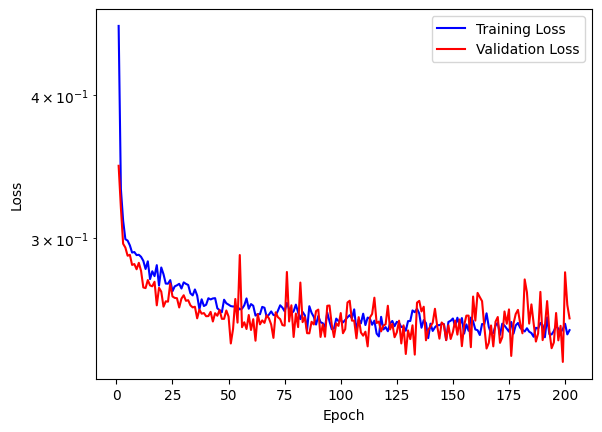

Epoch 010 | Train Loss: 0.2903 | Val Loss: 0.2856 | Acc: 0.8875
Epoch 020 | Train Loss: 0.2829 | Val Loss: 0.2695 | Acc: 0.9000
Epoch 030 | Train Loss: 0.2746 | Val Loss: 0.2675 | Acc: 0.8969
Epoch 040 | Train Loss: 0.2625 | Val Loss: 0.2565 | Acc: 0.9016
Epoch 050 | Train Loss: 0.2625 | Val Loss: 0.2563 | Acc: 0.8953
Epoch 060 | Train Loss: 0.2628 | Val Loss: 0.2495 | Acc: 0.8953
Epoch 070 | Train Loss: 0.2571 | Val Loss: 0.2455 | Acc: 0.9062
Epoch 080 | Train Loss: 0.2625 | Val Loss: 0.2579 | Acc: 0.9016
Epoch 090 | Train Loss: 0.2566 | Val Loss: 0.2599 | Acc: 0.9062
Epoch 100 | Train Loss: 0.2545 | Val Loss: 0.2581 | Acc: 0.9109
Epoch 110 | Train Loss: 0.2578 | Val Loss: 0.2466 | Acc: 0.9094
Epoch 120 | Train Loss: 0.2509 | Val Loss: 0.2523 | Acc: 0.9094
Epoch 130 | Train Loss: 0.2540 | Val Loss: 0.2493 | Acc: 0.9062
Epoch 140 | Train Loss: 0.2527 | Val Loss: 0.2512 | Acc: 0.9141
Epoch 150 | Train Loss: 0.2553 | Val Loss: 0.2485 | Acc: 0.9156
Epoch 160 | Train Loss: 0.2497 | Val Los

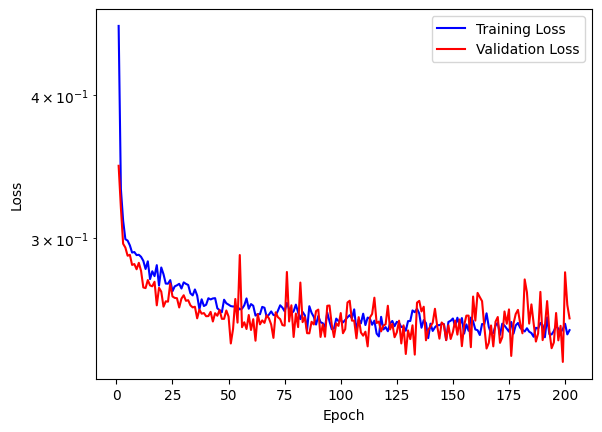

In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = simpleGAT(in_channels=train_set[0].x.size(1), hidden_channels=32,
#            out_channels=train_set[0].y.size(0), heads=4, dropout=0.6).to(device)
model = simpleGAT(in_channels=train_set[0].x.size(1), hidden_channels=32,
            out_channels=train_set[0].y.size(0), heads=4, dropout=0.6).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

plot = LossPlot()

loss_func=torch.nn.BCEWithLogitsLoss()

for epoch in range(1, 501):
    model.train()
    total_loss=0
    for batch in train_dataloader:
        batch=batch.to(device) 
        opt.zero_grad() 
        out=model(batch)
        loss = loss_func(out, torch.unsqueeze(batch.y,1))
        #F.cross_entropy(out,batch.y.long()) 
        loss.backward() 
        opt.step() 
        total_loss+=loss.item()
    preds, labels = evaluate(model, val_dataloader)
    #y_true = labels.numpy().astype(int)
    #y_probs = F.softmax(F.sigmoid(preds), dim=1).numpy()
    val_loss = loss_func(preds, labels).item() 
    #F.cross_entropy(preds, labels.long()).item()
    plot.UpdatePlots(epoch, total_loss/len(train_dataloader), val_loss)
    ypred = np.array([1 if p>0.5 else 0 for p in torch.sigmoid(preds)])
    acc = accuracy_score(labels.numpy(), ypred)
    if epoch % 10 ==0:
        print(f"Epoch {epoch:03d} | Train Loss: {total_loss / len(train_dataloader):.4f} | Val Loss: {val_loss:.4f} | Acc: {acc:.4f}")
    if acc > 0.925:
        break

    # Early stopping
    #if val_loss<best_val_loss:
    #    best_val_loss=val_loss; patience=0
    #    torch.save(model.state_dict(), os.path.join(results_dir, f"fold{fold+1}_model.pt"))
    #else:
    #    patience+=1
    #    if patience>=10: break

#print(f"Best val loss: {best_val_loss:.4f} | Early stopping patience: {patience}")

In [111]:
print(acc)

0.928125


0.865625


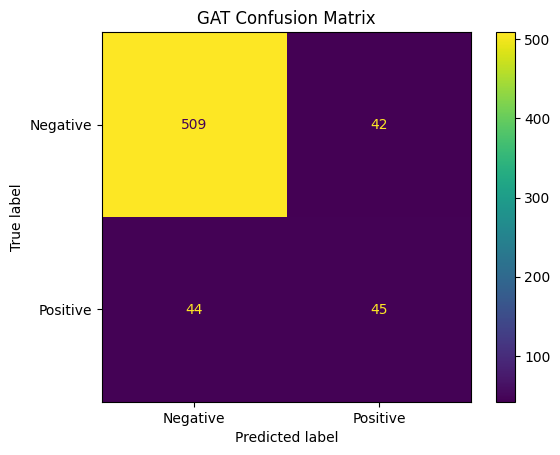

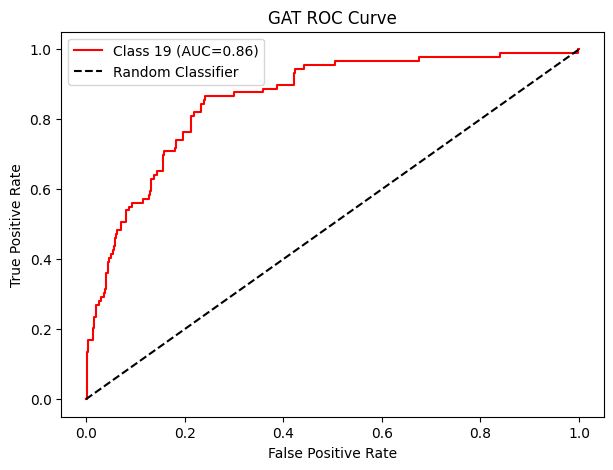

In [113]:
preds_test, labels_test = evaluate(model, test_dataloader)
preds_prob_test = torch.sigmoid(preds_test)
ypred_test = np.array([1 if p>0.5 else 0 for p in preds_prob_test])
acc_test = accuracy_score(labels_test.numpy(), ypred_test)
print(acc_test)

# Confusion matrix
c_matrix = confusion_matrix(labels_test.numpy(), ypred_test)
disp = ConfusionMatrixDisplay(
    c_matrix, display_labels=["Negative","Positive"]
)
disp.plot() 
plt.title("GAT Confusion Matrix") 
plt.savefig('GAT_confusion.pdf')
plt.show()

# AUC by class
y_true_bin = label_binarize(labels_test.numpy(), classes=np.arange(2))
plt.figure(figsize=(7,5))
fpr, tpr, _ = roc_curve(y_true_bin[:, 0], preds_prob_test.numpy())
plt.plot(fpr, tpr, "r-", label=f"Class {i} (AUC={auc(fpr, tpr):.2f})")
plt.plot([0,1], [0,1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("GAT ROC Curve") 
plt.legend() 
plt.savefig('GAT_ROC.pdf')
plt.show()